In [ ]:
import pandas as pd
import igraph as ig
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math

df = pd.read_csv('./RQ3/adversarial_commit_details.csv', dtype={'commit_time': str})
print(df.columns)

unique_developers = sorted(df['developer'].unique())
print("Unique Developers:", unique_developers)

unique_projects = sorted(df['project'].unique())
print("Unique Projects:", unique_projects)

Index(['developer', 'project', 'commit_time',
       'earliest_adversarial_commit_time', 'commit_count'],
      dtype='object')
Unique Developers: ['Developer1', 'Developer10', 'Developer11', 'Developer12', 'Developer13', 'Developer15', 'Developer16', 'Developer3', 'Developer4', 'Developer5', 'Developer7', 'Developer8']
Unique Projects: ['Project1', 'Project10', 'Project11', 'Project12', 'Project13', 'Project14', 'Project2', 'Project3', 'Project5', 'Project6', 'Project7', 'Project9']


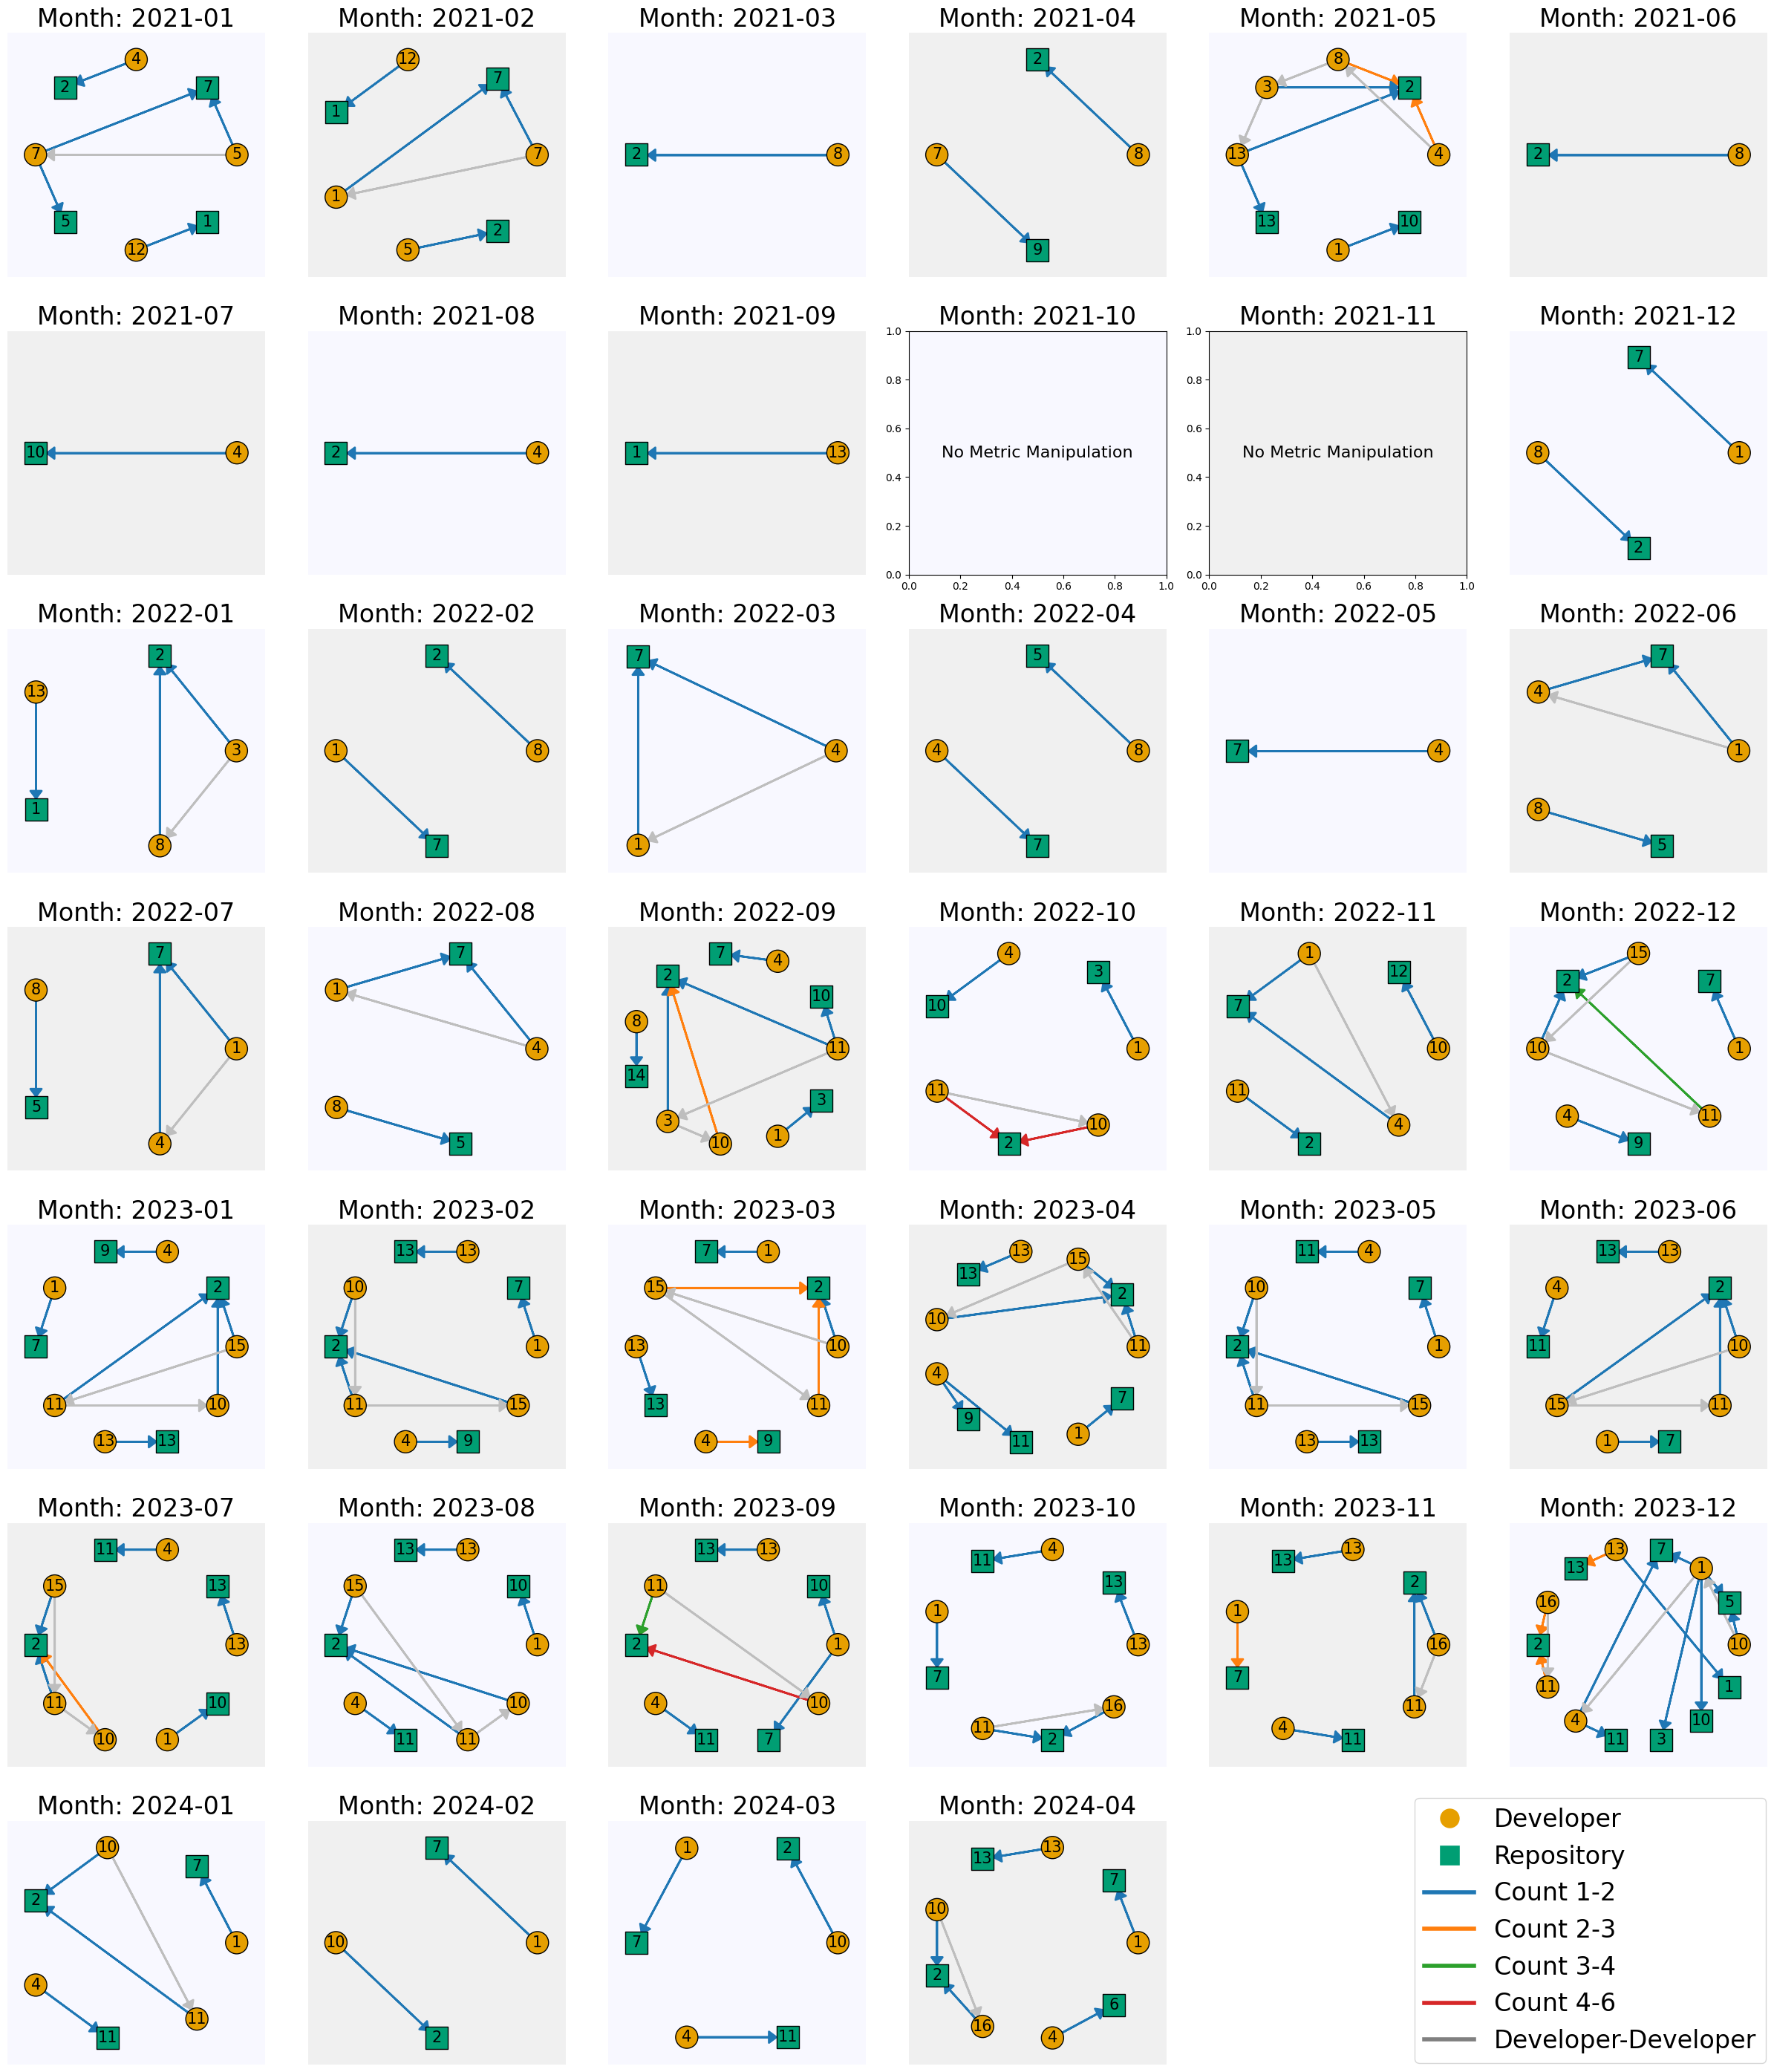

In [ ]:
import pandas as pd
import igraph as ig
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math
df = pd.read_csv('./RQ3/adversarial_commit_details.csv', dtype={'commit_time': str})

df['commit_time'] = pd.to_datetime(df['commit_time'], format='%Y.%m')

df = df.sort_values(by='commit_time')

df = df[df['commit_time'] >= pd.to_datetime('2021-01')]

df['month'] = df['commit_time'].dt.to_period('M')

months = pd.date_range(start='2021-01', end='2024-05', freq='M').to_period('M')

months = list(months)

num_plots = len(months)
num_rows = (num_plots + 5) // 6 

fig, axes = plt.subplots(num_rows, 6, figsize=(24, 4 * num_rows))
axes = axes.flatten() 

color_map = ['#E69F00', '#009E73']

background_colors = ['#F8F8FF', '#F0F0F0']  
centrality_results = []
density_results = []

min_count = min(df['commit_count'])
max_count = max(df['commit_count'])

intervals = [(min_count + i * (max_count - min_count) / 4, min_count + (i + 1) * (max_count - min_count) / 4) for i in range(4)]

edge_color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
graph_list=[]

for idx, month in enumerate(months):
    ax = axes[idx]
    group = df[df['month'] == month]

    graph = ig.Graph(directed=True)

    nodes = set()

    edge_strength = {}

    added_edges = set()
    
    for _, row in group.iterrows():
        developer = row['developer']
        project = row['project']
        commit_time = row['commit_time']

        if developer not in nodes:
            graph.add_vertex(name=developer, type='developer') 
            nodes.add(developer)
        if project not in nodes:
            graph.add_vertex(name=project, type='project')  
            nodes.add(project)

        if (developer, project) not in edge_strength:
            edge_strength[(developer, project)] = {'count': 0, 'time': commit_time}
        edge_strength[(developer, project)]['count'] += row['commit_count']
        edge_strength[(developer, project)]['time'] = max(edge_strength[(developer, project)]['time'], commit_time)

    edge_colors = []
    for (developer, project), data in edge_strength.items():
        if developer != project: 
            graph.add_edge(developer, project, weight=data['count'], time=data['time'])

            for i, (low, high) in enumerate(intervals):
                if low <= data['count'] < high:
                    edge_colors.append(edge_color_map[i])
                    break
            else:
                edge_colors.append(edge_color_map[-1])  
    project_groups = group.groupby('project')
    for project, project_group in project_groups:
        project_group = project_group.sort_values(by='commit_time')
        developers = project_group['developer'].tolist()
        
        for i in range(len(developers) - 1):
            dev1 = developers[i]
            dev2 = developers[i + 1]
            
            if dev1 != dev2 and (dev1, dev2) not in added_edges: 
                graph.add_edge(dev1, dev2)
                added_edges.add((dev1, dev2))
                edge_colors.append('gray')  

    if len(nodes)>0:
        degree_centrality = dict(zip(graph.vs['name'], graph.degree()))
        betweenness_centrality = dict(zip(graph.vs['name'], graph.betweenness()))
        closeness_centrality = dict(zip(graph.vs['name'], graph.closeness()))

        num_vertices = graph.vcount()
        num_edges = graph.ecount()
        max_possible_edges = num_vertices * (num_vertices - 1)  
        density = graph.density(loops=False)

        centrality_results.append({
            'month': month,
            'degree_centrality': degree_centrality,
            'betweenness_centrality': betweenness_centrality,
            'closeness_centrality': closeness_centrality
        })
        density_results.append({
            'month': month,
            'density': density
        })
        
        node_colors = []
        node_shapes = []
        for v in graph.vs:
            if v['type'] == 'developer':
                node_colors.append(color_map[0]) 
                node_shapes.append('o')  
            elif v['type'] == 'project':
                node_colors.append(color_map[1]) 
                node_shapes.append('s') 

        for item in graph.vs:
            if item['name'].startswith('Developer'):
                item['name']=item['name'].replace('Developer', '')
            elif item['name'].startswith('Project'):
                item['name']=item['name'].replace('Project', '')
        
        
        layout = graph.layout("circle")
        ig.plot(
            graph,
            layout=layout,
            vertex_label=graph.vs["name"],
            vertex_label_size=15,
            vertex_size=30,
            vertex_color=node_colors,  
            vertex_shape=node_shapes,  
            edge_arrow_size=10,
            edge_color=edge_colors,  
            bbox=(400, 400),
            margin=0,
            target=ax
        )

        ax.set_title(f'Month: {month}',fontsize=24)

        ax.set_facecolor(background_colors[(idx % 2 + idx//6)%2])
    else:
        ax.set_title(f'Month: {month}',fontsize=24)
        ax.text(0.5, 0.5, f'No Metric Manipulation', ha='center', va='center', fontsize=16)
        ax.set_facecolor(background_colors[(idx % 2 + idx//6)%2])
    graph_list.append(graph)
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes.flatten()[idx])  


legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Developer',
               markerfacecolor=color_map[0], markersize=20),
    plt.Line2D([0], [0], marker='s', color='w', label='Repository',
               markerfacecolor=color_map[1], markersize=20),
] + [plt.Line2D([0], [0], color=color, lw=4, label=f'Count {math.floor(intervals[i][0])}-{math.floor(intervals[i][1])}') for i, color in enumerate(edge_color_map)] + [plt.Line2D([0], [0], color='gray', lw=4, label='Developer-Developer')]

fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1, 0), fontsize=24)
plt.tight_layout()
plt.savefig('RQ3_graph.pdf')
plt.show()

In [ ]:
print(centrality_results)
print(density_results)
import json

centrality_results_serializable = [
    {key: (value.to_timestamp().isoformat() if isinstance(value, pd.Period) else value)
     for key, value in item.items()}
    if isinstance(item, dict) else
    (item.to_timestamp().isoformat() if isinstance(item, pd.Period) else item)
    for item in centrality_results
]

with open('centrality_results.json', 'w') as json_file:
    json.dump(centrality_results_serializable, json_file, indent=4)

[{'month': Period('2021-01', 'M'), 'degree_centrality': {'Developer5': 2, 'Project7': 2, 'Developer4': 1, 'Project2': 1, 'Developer7': 3, 'Project5': 1, 'Developer12': 1, 'Project1': 1}, 'betweenness_centrality': {'Developer5': 0.0, 'Project7': 0.0, 'Developer4': 0.0, 'Project2': 0.0, 'Developer7': 1.0, 'Project5': 0.0, 'Developer12': 0.0, 'Project1': 0.0}, 'closeness_centrality': {'Developer5': 0.75, 'Project7': 0.75, 'Developer4': 1.0, 'Project2': 1.0, 'Developer7': 1.0, 'Project5': 0.6, 'Developer12': 1.0, 'Project1': 1.0}}, {'month': Period('2021-02', 'M'), 'degree_centrality': {'Developer7': 2, 'Project7': 2, 'Developer12': 1, 'Project1': 1, 'Developer1': 2, 'Developer5': 1, 'Project2': 1}, 'betweenness_centrality': {'Developer7': 0.0, 'Project7': 0.0, 'Developer12': 0.0, 'Project1': 0.0, 'Developer1': 0.0, 'Developer5': 0.0, 'Project2': 0.0}, 'closeness_centrality': {'Developer7': 1.0, 'Project7': 1.0, 'Developer12': 1.0, 'Project1': 1.0, 'Developer1': 1.0, 'Developer5': 1.0, 'Pr

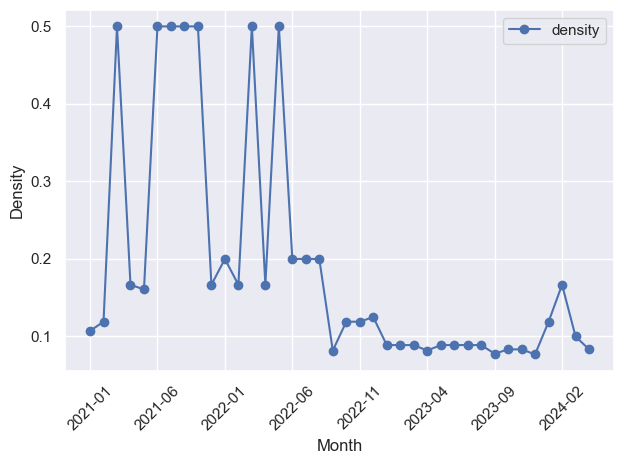

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  
sns.set_theme(style="darkgrid")
density_df = pd.DataFrame(density_results)

density_df['month'] = density_df['month'].astype(str)

df_sorted = density_df.sort_values(by='month')


average_density = density_df['density'].mean()

density_df.plot(x='month', y='density', kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Density')
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.savefig('RQ3_density_plot.pdf')
plt.show()

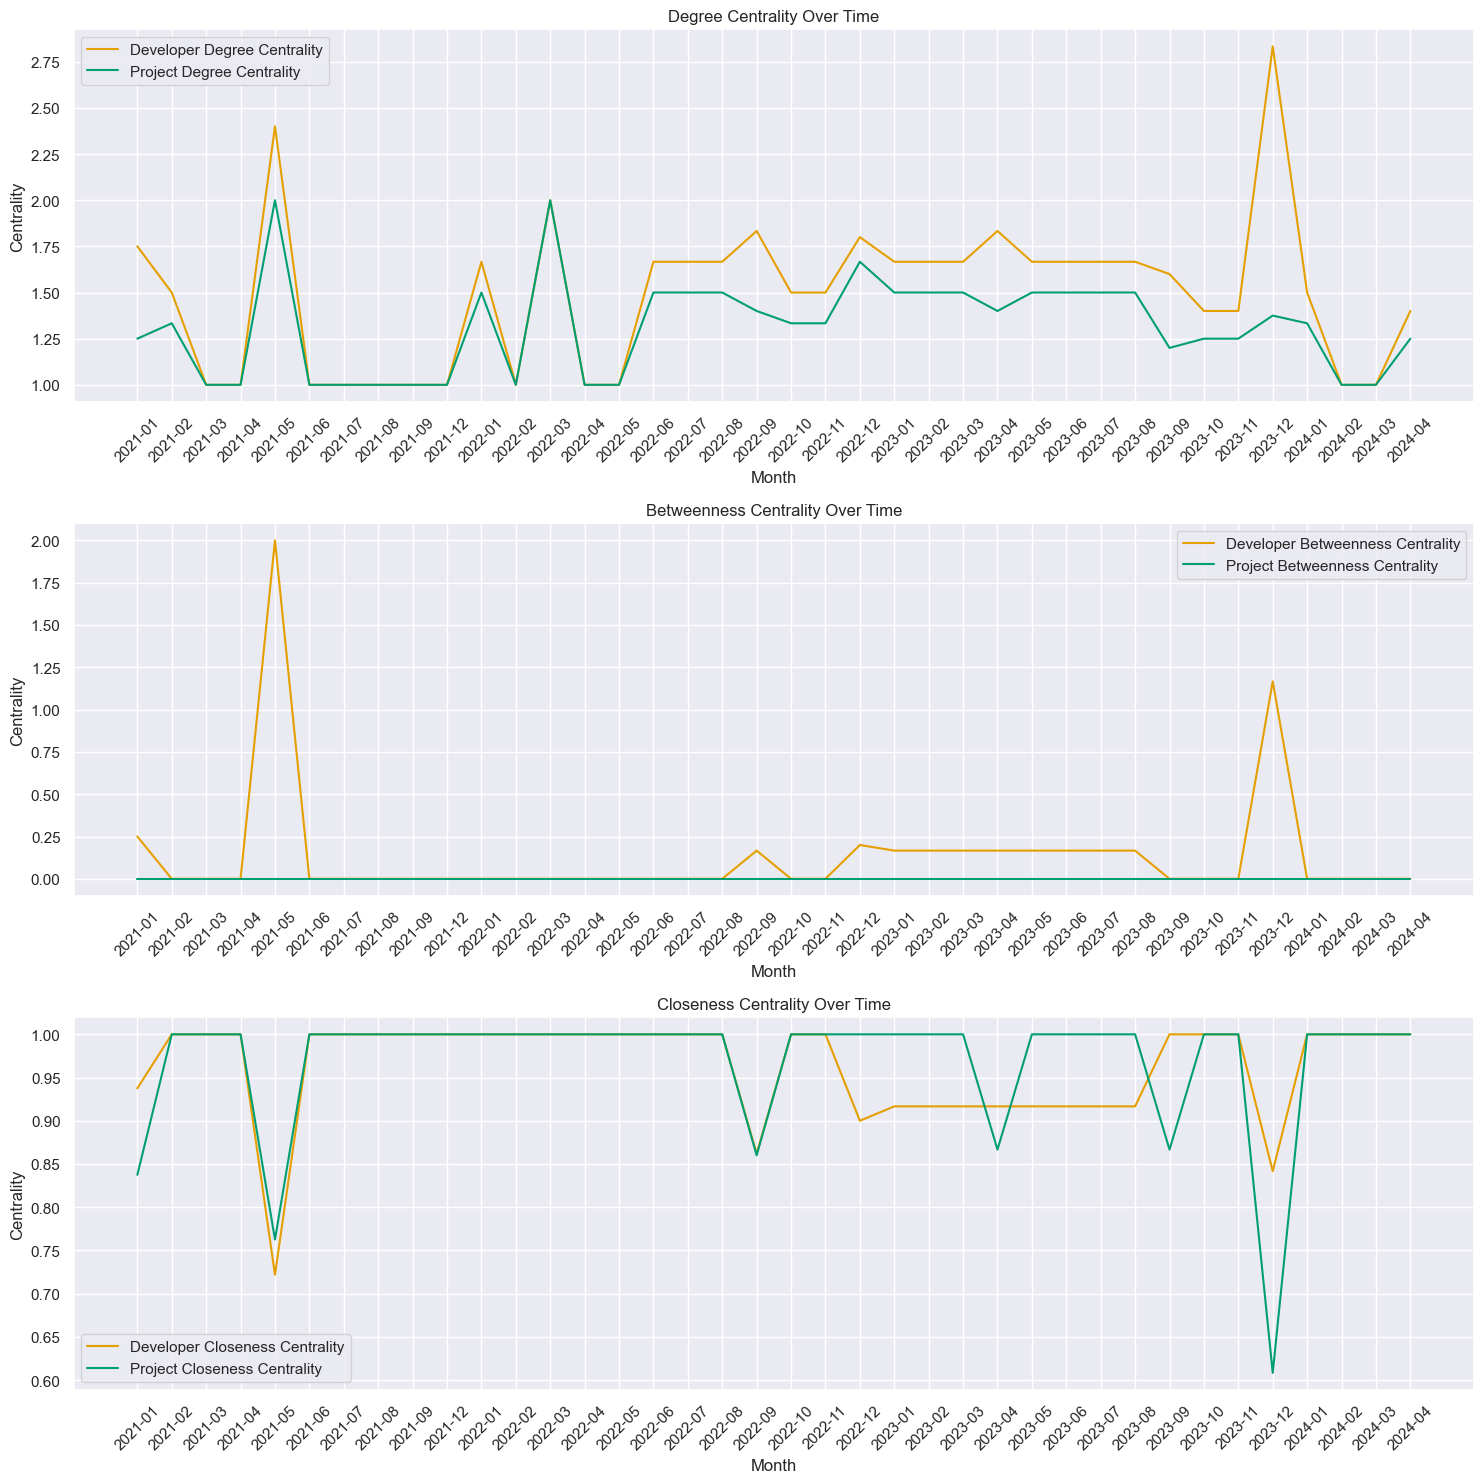

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

developer_degree_centrality = []
developer_betweenness_centrality = []
developer_closeness_centrality = []

project_degree_centrality = []
project_betweenness_centrality = []
project_closeness_centrality = []

months = []

for result in centrality_results:
    month = result['month']
    months.append(month)
    
    dev_degree = [v for k, v in result['degree_centrality'].items() if k.startswith('Dev')]
    dev_betweenness = [v for k, v in result['betweenness_centrality'].items() if k.startswith('Dev')]
    dev_closeness = [v for k, v in result['closeness_centrality'].items() if k.startswith('Dev')]
    
    if dev_degree:
        developer_degree_centrality.append(np.mean(dev_degree))
    else:
        developer_degree_centrality.append(0)
    
    if dev_betweenness:
        developer_betweenness_centrality.append(np.mean(dev_betweenness))
    else:
        developer_betweenness_centrality.append(0)
    
    if dev_closeness:
        developer_closeness_centrality.append(np.mean(dev_closeness))
    else:
        developer_closeness_centrality.append(0)
    
    proj_degree = [v for k, v in result['degree_centrality'].items() if k.startswith('Proj')]
    proj_betweenness = [v for k, v in result['betweenness_centrality'].items() if k.startswith('Proj')]
    proj_closeness = [v for k, v in result['closeness_centrality'].items() if k.startswith('Proj')]
    
    if proj_degree:
        project_degree_centrality.append(np.mean(proj_degree))
    else:
        project_degree_centrality.append(0)
    
    if proj_betweenness:
        project_betweenness_centrality.append(np.mean(proj_betweenness))
    else:
        project_betweenness_centrality.append(0)
    
    if proj_closeness:
        project_closeness_centrality.append(np.mean(proj_closeness))
    else:
        project_closeness_centrality.append(0)

fig, axs = plt.subplots(3, 1, figsize=(15, 15))

months_str = [str(month) for month in months]

axs[0].plot(months_str, developer_degree_centrality, label='Developer Degree Centrality', color=color_map[0])
axs[0].plot(months_str, project_degree_centrality, label='Project Degree Centrality', color=color_map[1])
axs[0].set_title('Degree Centrality Over Time')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Centrality')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)  
axs[1].plot(months_str, developer_betweenness_centrality, label='Developer Betweenness Centrality', color=color_map[0])
axs[1].plot(months_str, project_betweenness_centrality, label='Project Betweenness Centrality', color=color_map[1])
axs[1].set_title('Betweenness Centrality Over Time')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Centrality')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)  
axs[2].plot(months_str, developer_closeness_centrality, label='Developer Closeness Centrality', color=color_map[0])
axs[2].plot(months_str, project_closeness_centrality, label='Project Closeness Centrality', color=color_map[1])
axs[2].set_title('Closeness Centrality Over Time')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Centrality')
axs[2].legend()
axs[2].tick_params(axis='x', rotation=45)  
plt.tight_layout()
plt.savefig('RQ3_centrality_over_time.pdf')
plt.show()

In [ ]:
df['month'] = df['commit_time'].dt.to_period('M')

monthly_unique_developers = df.groupby('month')['developer'].nunique().reset_index(name='unique_developers')

monthly_unique_projects = df.groupby('month')['project'].nunique().reset_index(name='unique_projects')

tmp_df = pd.read_excel('./RQ3/RQ3_allid_25250101_fill.xlsx')

tmp_df['submit_date'] = pd.to_datetime(tmp_df['commit_date'])

tmp_df['month'] = tmp_df['submit_date'].dt.to_period('M')

monthly_developer_count = tmp_df.groupby(['month', 'Developer_id']).size().reset_index(name='count')
monthly_project_count = tmp_df.groupby(['month', 'Project_id']).size().reset_index(name='count')

monthly_unique_developers_all = monthly_developer_count.groupby('month').size().reset_index(name='unique_developer_count')

monthly_unique_projects_all = monthly_project_count.groupby('month').size().reset_index(name='unique_project_count')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_28208\217007076.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tmp_df['month'] = tmp_df['submit_date'].dt.to_period('M')


      month  unique_developers  unique_projects  unique_developer_count  \
0   2021-01                  4                4                       6   
1   2021-02                  4                3                       6   
2   2021-03                  1                1                       7   
3   2021-04                  2                2                       5   
4   2021-05                  5                3                       6   
5   2021-06                  1                1                       5   
6   2021-07                  1                1                       5   
7   2021-08                  1                1                       4   
8   2021-09                  1                1                       5   
9   2021-10                  0                0                       0   
10  2021-11                  0                0                       0   
11  2021-12                  2                2                       6   
12  2022-01              

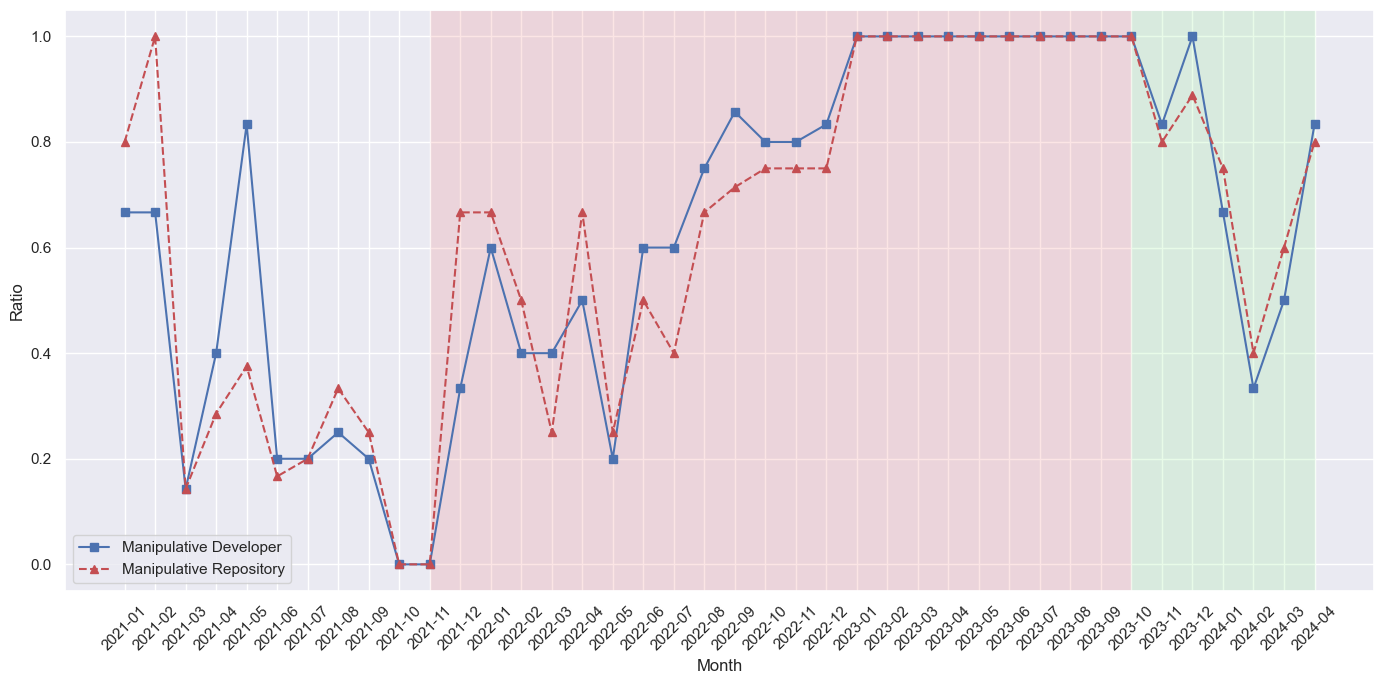

In [ ]:
monthly_stats = pd.merge(monthly_unique_developers, monthly_unique_projects, on='month')
monthly_stats = pd.merge(monthly_stats, monthly_unique_developers_all, on='month')
monthly_stats = pd.merge(monthly_stats, monthly_unique_projects_all, on='month')

monthly_stats['developer_ratio'] = monthly_stats['unique_developers'] / monthly_stats['unique_developer_count']

monthly_stats['project_ratio'] = monthly_stats['unique_projects'] / monthly_stats['unique_project_count']
monthly_stats['project_ratio'] = monthly_stats['project_ratio'].clip(upper=1)

additional_months = pd.DataFrame({
    'month': list(pd.date_range(start='2021-10', end='2021-12', freq='M').to_period('M')),
    'unique_developers': [0, 0],
    'unique_projects': [0, 0],
    'unique_developer_count': [0, 0],
    'unique_project_count': [0, 0],
    'developer_ratio': [0, 0],
    'project_ratio': [0, 0]
})

monthly_stats = pd.concat([monthly_stats, additional_months], ignore_index=True)

monthly_stats = monthly_stats.sort_values(by='month').reset_index(drop=True)

print(monthly_stats)

plt.figure(figsize=(14, 7))

plt.plot(monthly_stats['month'].astype(str), monthly_stats['developer_ratio'], label='Manipulative Developer', linestyle='-', marker='s', color='b')  # 实线，方形标记，蓝色
plt.plot(monthly_stats['month'].astype(str), monthly_stats['project_ratio'], label='Manipulative Repository', linestyle='--', marker='^', color='r')  # 虚线，三角形标记，红色

num_x = len(monthly_stats['month'])

plt.axvspan(10, 33, facecolor='lightcoral', alpha=0.2)

plt.axvspan(33, 39, facecolor='lightgreen', alpha=0.2)

#plt.title('Monthly Developer and Project Submission Ratios')
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_submission_ratios.pdf')
plt.show()



In [ ]:
developer_ratio_stats = {
    'max': filtered_df['developer_ratio'].max(),
    'min': filtered_df['developer_ratio'].min(),
    'mean': filtered_df['developer_ratio'].mean(),
    'std': filtered_df['developer_ratio'].std()
}

project_ratio_stats = {
    'max': filtered_df['project_ratio'].max(),
    'min': filtered_df['project_ratio'].min(),
    'mean': filtered_df['project_ratio'].mean(),
    'std': filtered_df['project_ratio'].std()
}

print("\nStatistics for Developer Ratio:")
print(developer_ratio_stats)

print("\nStatistics for Project Ratio:")
print(project_ratio_stats)


Statistics for Developer Ratio:
{'max': 0.8333333333333334, 'min': 0.3333333333333333, 'mean': 0.5833333333333334, 'std': 0.21516574145596762}

Statistics for Project Ratio:
{'max': 0.8, 'min': 0.4, 'mean': 0.6375, 'std': 0.17969882210706523}


In [ ]:
import pymannkendall as mk
start_date = '2021-01-01'
end_date = '2024-02-31'
filtered_df = monthly_stats[(monthly_stats['month'] >= start_date) & (monthly_stats['month'] <= end_date)]

result_developer_ratio = mk.original_test(filtered_df['developer_ratio'])
result_new_developers_ratio = mk.original_test(filtered_df['new_developers_ratio'])
result_reduced_developers_ratio = mk.original_test(filtered_df['new_developers_ratio'])
result_project_ratio = mk.original_test(filtered_df['project_ratio'])
result_new_projects_ratio = mk.original_test(filtered_df['new_projects_ratio'])
result_reduced_projects_ratio = mk.original_test(filtered_df['reduced_projects_ratio'])
print("Mann-Kendall Test for Developer Ratio:")
print(result_developer_ratio)
print("\nMann-Kendall Test for Project Ratio:")
print(result_project_ratio)
print("\nMann-Kendall Test for New Developers Ratio:")
print(result_new_developers_ratio)
print("\nMann-Kendall Test for Project Ratio:")
print(result_reduced_developers_ratio)
print("\nMann-Kendall Test for New Projects Ratio:")
print(result_new_projects_ratio)
print("\nMann-Kendall Test for Reduced Projects Ratio:")
print(result_reduced_projects_ratio)


Mann-Kendall Test for Developer Ratio:
Mann_Kendall_Test(trend='increasing', h=True, p=5.852926537874836e-06, z=4.5316337345465705, Tau=0.5277310924369748, s=314.0, var_s=4770.666666666667, slope=0.024, intercept=0.34199999999999997)

Mann-Kendall Test for Project Ratio:
Mann_Kendall_Test(trend='increasing', h=True, p=6.843698610037308e-06, z=4.49849257545888, Tau=0.5260504201680672, s=313.0, var_s=4810.333333333333, slope=0.025, intercept=0.28928571428571426)

Mann-Kendall Test for New Developers Ratio:
Mann_Kendall_Test(trend='no trend', h=False, p=0.3719498729852808, z=-0.8928269102086166, Tau=-0.08235294117647059, s=-49.0, var_s=2890.3333333333335, slope=0.0, intercept=0.0)

Mann-Kendall Test for Project Ratio:
Mann_Kendall_Test(trend='no trend', h=False, p=0.3719498729852808, z=-0.8928269102086166, Tau=-0.08235294117647059, s=-49.0, var_s=2890.3333333333335, slope=0.0, intercept=0.0)

Mann-Kendall Test for New Projects Ratio:
Mann_Kendall_Test(trend='no trend', h=False, p=0.626420